In [33]:
!pip install -q -r requirements.txt


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

In [35]:
X_train = np.load('../notebooks/new_artifacts/X_train_new.npz', allow_pickle=True)['arr_0']
Y_train = np.load('../notebooks/new_artifacts/Y_train_new.npz', allow_pickle=True)['arr_0']
X_test  = np.load('../notebooks/new_artifacts/X_test_new.npz',  allow_pickle=True)['arr_0']
Y_test  = np.load('../notebooks/new_artifacts/Y_test_new.npz',  allow_pickle=True)['arr_0']


In [49]:
print("\nRANDOM FOREST (BAGGING)")
print("=" * 35)

# Basic Random Forest
print("Training basic Random Forest...")
rf_basic = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_basic.fit(X_train, Y_train)

# Predictions
rf_basic_pred = rf_basic.predict(X_test)
rf_basic_proba = rf_basic.predict_proba(X_test)[:, 1]
rf_basic_auc = roc_auc_score(Y_test, rf_basic_proba)

print(f"Basic Random Forest AUC: {rf_basic_auc:.3f}")


RANDOM FOREST (BAGGING)
Training basic Random Forest...
Basic Random Forest AUC: 0.831


In [51]:
print("Tuning Random Forest hyperparameters...")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Randomized search (faster than grid search)
rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=20,  # Try 20 random combinations
    cv=3,       # 3-fold cross validation
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Fit
rf_random_search.fit(X_train, Y_train)

# Best model
rf_best = rf_random_search.best_estimator_
print(f"Best Random Forest parameters: {rf_random_search.best_params_}")

# Predictions with best model
rf_best_pred = rf_best.predict(X_test)
rf_best_proba = rf_best.predict_proba(X_test)[:, 1]
rf_best_auc = roc_auc_score(Y_test, rf_best_proba)

print(f"Optimized Random Forest AUC: {rf_best_auc:.3f}")
print(f"Improvement: {rf_best_auc - rf_basic_auc:.3f}")

Tuning Random Forest hyperparameters...
Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
Optimized Random Forest AUC: 0.832
Improvement: 0.001


In [53]:
print("\nXGBOOST (BOOSTING)")
print("=" * 30)

# Basic XGBoost
print("Training basic XGBoost...")
xgb_basic = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss'  # Suppress warning
)
xgb_basic.fit(X_train, Y_train)

# Predictions
xgb_basic_pred = xgb_basic.predict(X_test)
xgb_basic_proba = xgb_basic.predict_proba(X_test)[:, 1]
xgb_basic_auc = roc_auc_score(Y_test, xgb_basic_proba)

print(f"Basic XGBoost AUC: {xgb_basic_auc:.3f}")


XGBOOST (BOOSTING)
Training basic XGBoost...
Basic XGBoost AUC: 0.827


In [54]:
print("Tuning XGBoost hyperparameters...")

# Define parameter grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# Randomized search
xgb_random_search = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=xgb_param_grid,
    n_iter=15,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Fit
xgb_random_search.fit(X_train, Y_train)

# Best model
xgb_best = xgb_random_search.best_estimator_
print(f"Best XGBoost parameters: {xgb_random_search.best_params_}")

# Predictions with best model
xgb_best_pred = xgb_best.predict(X_test)
xgb_best_proba = xgb_best.predict_proba(X_test)[:, 1]
xgb_best_auc = roc_auc_score(Y_test, xgb_best_proba)

print(f"Optimized XGBoost AUC: {xgb_best_auc:.3f}")
print(f"Improvement: {xgb_best_auc - xgb_basic_auc:.3f}")

Tuning XGBoost hyperparameters...
Best XGBoost parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1}
Optimized XGBoost AUC: 0.831
Improvement: 0.004


In [55]:
print("\nCATBOOST (ADVANCED BOOSTING)")
print("=" * 40)

# Basic CatBoost
print("Training basic CatBoost...")
cb_basic = cb.CatBoostClassifier(
    random_seed=42,
    verbose=False  # Suppress training output
)
cb_basic.fit(X_train, Y_train)

# Predictions
cb_basic_pred = cb_basic.predict(X_test)
cb_basic_proba = cb_basic.predict_proba(X_test)[:, 1]
cb_basic_auc = roc_auc_score(Y_test, cb_basic_proba)

print(f"Basic CatBoost AUC: {cb_basic_auc:.3f}")


CATBOOST (ADVANCED BOOSTING)
Training basic CatBoost...
Basic CatBoost AUC: 0.838


In [56]:
print("Tuning CatBoost hyperparameters...")

# Define parameter grid
cb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5]
}

# Randomized search
cb_random_search = RandomizedSearchCV(
    cb.CatBoostClassifier(random_seed=42, verbose=False),
    param_distributions=cb_param_grid,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Fit
cb_random_search.fit(X_train, Y_train)

# Best model
cb_best = cb_random_search.best_estimator_
print(f"Best CatBoost parameters: {cb_random_search.best_params_}")

# Predictions with best model
cb_best_pred = cb_best.predict(X_test)
cb_best_proba = cb_best.predict_proba(X_test)[:, 1]
cb_best_auc = roc_auc_score(Y_test, cb_best_proba)

print(f"Optimized CatBoost AUC: {cb_best_auc:.3f}")
print(f"Improvement: {cb_best_auc - cb_basic_auc:.3f}")

Tuning CatBoost hyperparameters...
Best CatBoost parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}
Optimized CatBoost AUC: 0.836
Improvement: -0.002


In [58]:
print("BASELINE MODELS")
print("=" * 30)

# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, Y_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Performance
lr_auc = roc_auc_score(Y_test, lr_pred_proba)
print(f"Logistic Regression AUC: {lr_auc:.3f}")

# Store results
baseline_results = {
    'Logistic Regression': {
        'model': lr_model,
        'predictions': lr_pred,
        'probabilities': lr_pred_proba,
        'auc': lr_auc
    }
}

BASELINE MODELS
Training Logistic Regression...
Logistic Regression AUC: 0.836


In [59]:
# Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train, Y_train)

# Predictions
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Performance
dt_auc = roc_auc_score(Y_test, dt_pred_proba)
print(f"Decision Tree AUC: {dt_auc:.3f}")

# Store results
baseline_results['Decision Tree'] = {
    'model': dt_model,
    'predictions': dt_pred,
    'probabilities': dt_pred_proba,
    'auc': dt_auc
}

print("✅ Baseline models trained!")

Training Decision Tree...
Decision Tree AUC: 0.742
✅ Baseline models trained!


In [60]:
print("\nMODEL COMPARISON")
print("=" * 30)

# Store all results
all_results = {
    'Logistic Regression': baseline_results['Logistic Regression']['auc'],
    'Decision Tree': baseline_results['Decision Tree']['auc'],
    'Random Forest (Basic)': rf_basic_auc,
    'Random Forest (Tuned)': rf_best_auc,
    'XGBoost (Basic)': xgb_basic_auc,
    'XGBoost (Tuned)': xgb_best_auc,
    'CatBoost (Basic)': cb_basic_auc,
    'CatBoost (Tuned)': cb_best_auc
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'AUC Score': list(all_results.values())
}).sort_values('AUC Score', ascending=False)

print("AUC Score Ranking:")
print("=" * 25)
for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{i:2d}. {row['Model']:<25} {row['AUC Score']:.3f}")


MODEL COMPARISON
AUC Score Ranking:
 1. CatBoost (Basic)          0.838
 2. CatBoost (Tuned)          0.836
 3. Logistic Regression       0.836
 4. Random Forest (Tuned)     0.832
 5. Random Forest (Basic)     0.831
 6. XGBoost (Tuned)           0.831
 7. XGBoost (Basic)           0.827
 8. Decision Tree             0.742


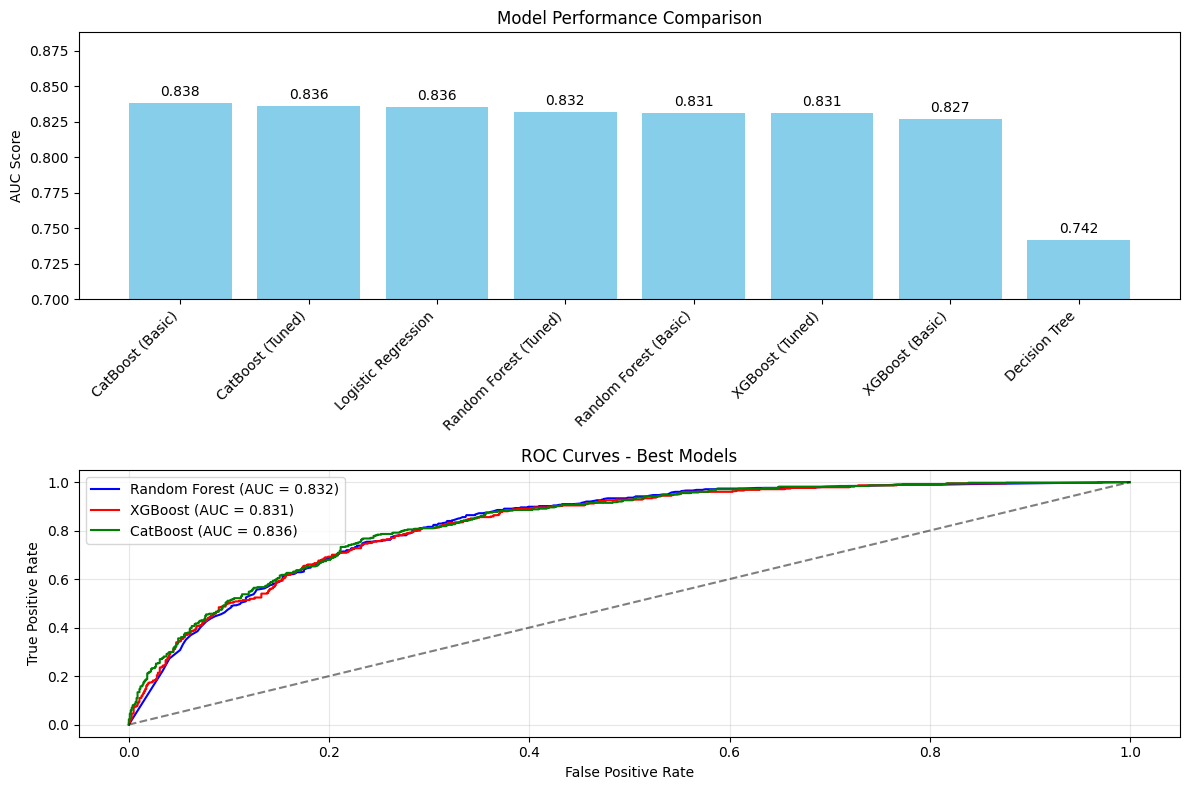

In [62]:
# Plot comparison
plt.figure(figsize=(12, 8))

# Bar plot
plt.subplot(2, 1, 1)
plt.bar(range(len(comparison_df)), comparison_df['AUC Score'], color='skyblue')
plt.xticks(range(len(comparison_df)), comparison_df['Model'], rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison')
plt.ylim(0.7, max(comparison_df['AUC Score']) + 0.05)

# Add value labels on bars
for i, v in enumerate(comparison_df['AUC Score']):
    plt.text(i, v + 0.005, f'{v:.3f}', ha='center')

# ROC Curves for best models
plt.subplot(2, 1, 2)

# Get top 3 models
top_models = [
    ('Random Forest', rf_best, rf_best_proba),
    ('XGBoost', xgb_best, xgb_best_proba),
    ('CatBoost', cb_best, cb_best_proba)
]

colors = ['blue', 'red', 'green']
for (name, model, proba), color in zip(top_models, colors):
    fpr, tpr, _ = roc_curve(Y_test, proba)
    auc_score = roc_auc_score(Y_test, proba)
    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Best Models')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['AUC Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC Score: {best_auc:.3f}")

# Get the actual best model object
best_model = None
best_pred = None
best_proba = None

if 'Random Forest' in best_model_name:
    best_model = rf_best
    best_pred = rf_best_pred
    best_proba = rf_best_proba
elif 'XGBoost' in best_model_name:
    best_model = xgb_best
    best_pred = xgb_best_pred
    best_proba = xgb_best_proba
elif 'CatBoost' in best_model_name:
    best_model = cb_best
    best_pred = cb_best_pred
    best_proba = cb_best_proba
else:
    raise ValueError(f"Unknown model name: {best_model_name}")

print(f"\n📊 QUICK PERFORMANCE CHECK:")
print("=" * 35)
print(classification_report(Y_test, best_pred, target_names=['No Churn', 'Churn']))

# Save best model
import joblib
joblib.dump(best_model, 'best_ensemble_model.pkl')
print(f"\n💾 Best model saved as: best_ensemble_model.pkl")



🏆 BEST MODEL: CatBoost (Basic)
   AUC Score: 0.838

📊 QUICK PERFORMANCE CHECK:
              precision    recall  f1-score   support

    No Churn       0.91      0.71      0.80      1035
       Churn       0.50      0.81      0.62       374

    accuracy                           0.73      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409


💾 Best model saved as: best_ensemble_model.pkl
